In [ ]:
!pip install pandas numpy yfinance polars pyarrow matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import yfinance as yf
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.grid"] = True

In [ ]:
import yfinance as yf

stock = "IOLCP.BO"

try:
    ticker = yf.Ticker(stock)
    data = ticker.history(period="1y")
    
    if data.empty:
        print(f"No data available for {stock}")
    else:
        print(f"Downloaded {len(data)} days of market data for {stock}")
        print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
except Exception as e:
    print(f"Error fetching stock data: {e}")

Downloaded 249 days of market data for IOLCP.BO
Date range: 2024-05-23 to 2025-05-23


In [ ]:
if not data.empty:
    data = data.reset_index()
    data.columns = [str(col) for col in data.columns]
    
    print(f"Summary statistics:")
    print(f"Average Close price: ${data['Close'].mean():.2f}")
    print(f"Min/Max Close: ${data['Close'].min():.2f} / ${data['Close'].max():.2f}")

Summary statistics:
Average Close price: $74.49
Min/Max Close: $59.31 / $97.21


In [ ]:
df = pl.from_pandas(data)

In [26]:
print(df)

shape: (249, 8)
┌──────────────┬───────────┬───────────┬───────────┬───────────┬────────┬───────────┬──────────────┐
│ Date         ┆ Open      ┆ High      ┆ Low       ┆ Close     ┆ Volume ┆ Dividends ┆ Stock Splits │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    ┆ ---       ┆ ---          │
│ datetime[ns, ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ i64    ┆ f64       ┆ f64          │
│ Asia/Kolkata ┆           ┆           ┆           ┆           ┆        ┆           ┆              │
│ ]            ┆           ┆           ┆           ┆           ┆        ┆           ┆              │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════╪═══════════╪══════════════╡
│ 2024-05-23   ┆ 70.599881 ┆ 71.032893 ┆ 69.752681 ┆ 69.903297 ┆ 56030  ┆ 0.0       ┆ 0.0          │
│ 00:00:00 IST ┆           ┆           ┆           ┆           ┆        ┆           ┆              │
│ 2024-05-24   ┆ 69.809168 ┆ 70.392789 ┆ 69.667967 ┆ 69.969193 ┆ 39080  ┆ 0

In [ ]:
df = df.select([
    pl.col("Date"),
    pl.col("Open"),
    pl.col("High"),
    pl.col("Low"),
    pl.col("Close"),
    pl.col("Volume"),
    (pl.col("Close") - pl.col("Open")).alias("Day_Change"),
    ((pl.col("Close") - pl.col("Open")) / pl.col("Open") * 100).alias("Day_Change_%")
])

In [28]:
print(df)

shape: (249, 8)
┌──────────────┬───────────┬───────────┬───────────┬───────────┬────────┬────────────┬─────────────┐
│ Date         ┆ Open      ┆ High      ┆ Low       ┆ Close     ┆ Volume ┆ Day_Change ┆ Day_Change_ │
│ ---          ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    ┆ ---        ┆ %           │
│ datetime[ns, ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ i64    ┆ f64        ┆ ---         │
│ Asia/Kolkata ┆           ┆           ┆           ┆           ┆        ┆            ┆ f64         │
│ ]            ┆           ┆           ┆           ┆           ┆        ┆            ┆             │
╞══════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════╪════════════╪═════════════╡
│ 2024-05-23   ┆ 70.599881 ┆ 71.032893 ┆ 69.752681 ┆ 69.903297 ┆ 56030  ┆ -0.696583  ┆ -0.986664   │
│ 00:00:00 IST ┆           ┆           ┆           ┆           ┆        ┆            ┆             │
│ 2024-05-24   ┆ 69.809168 ┆ 70.392789 ┆ 69.667967 ┆ 69.969193 ┆ 39080  ┆ 0

In [ ]:
def detect_signal(df_dicts):
    signals = []

    for i in range(2, len(df_dicts)):
        d0 = df_dicts[i - 2]
        d1 = df_dicts[i - 1]
        d2 = df_dicts[i]
        
        signal = "None"
        stoploss = None

        if (d0["Close"] < d0["Open"] and
            d1["Close"] < d1["Open"] and
            d2["Close"] > d2["Open"]):
            
            body_size = abs(d2["Close"] - d2["Open"])
            
            stoploss = round(d2["Close"] - 0.5 * body_size, 2)
            signal = "Buy"

        signals.append({
            "Date": d2["Date"],
            "Signal": signal,
            "Stoploss": stoploss,
            "Price": d2["Close"],
            "Open": d2["Open"],
            "High": d2["High"],
            "Low": d2["Low"]
        })

    return pl.DataFrame(signals)

In [ ]:
signals = detect_signal(df.to_dicts())

buy_signals = signals.filter(pl.col("Signal") == "Buy")
print(f"Total data points: {len(signals)}")
print(f"Total buy signals: {len(buy_signals)}")
print(f"Buy signal frequency: {len(buy_signals)/len(signals)*100:.2f}%")

Total data points: 247
Total buy signals: 36
Buy signal frequency: 14.57%


In [31]:
print(signals)

shape: (247, 7)
┌────────────────────────────┬────────┬──────────┬───────────┬───────────┬───────────┬───────────┐
│ Date                       ┆ Signal ┆ Stoploss ┆ Price     ┆ Open      ┆ High      ┆ Low       │
│ ---                        ┆ ---    ┆ ---      ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ datetime[μs, Asia/Kolkata] ┆ str    ┆ f64      ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════════════════════╪════════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2024-05-27 00:00:00 IST    ┆ None   ┆ null     ┆ 69.63031  ┆ 69.988014 ┆ 70.552811 ┆ 69.376146 │
│ 2024-05-28 00:00:00 IST    ┆ None   ┆ null     ┆ 68.143005 ┆ 69.630311 ┆ 70.035084 ┆ 67.785302 │
│ 2024-05-29 00:00:00 IST    ┆ Buy    ┆ 68.24    ┆ 68.707802 ┆ 67.775885 ┆ 69.752681 ┆ 67.775885 │
│ 2024-05-30 00:00:00 IST    ┆ None   ┆ null     ┆ 67.502899 ┆ 68.867835 ┆ 69.347909 ┆ 67.371113 │
│ 2024-05-31 00:00:00 IST    ┆ None   ┆ null     ┆ 67.700577 ┆ 67.907671 ┆ 68.143004 ┆ 67.446

In [ ]:
def generate_PNL(signals_df):
    trades = []
    holdings = False
    entry = {}

    signal_dicts = signals_df.to_dicts()
    for i in range(len(signal_dicts) - 1):
        sig = signal_dicts[i]
        next_day = signal_dicts[i + 1]

        if sig["Signal"] == "Buy" and not holdings:
            entry = {
                "Entry_Date": sig["Date"],
                "Entry_Price": sig["Price"],
                "Stoploss": sig["Stoploss"]
            }
            holdings = True

        elif holdings and (next_day["Signal"] != "Buy" or i == len(signal_dicts) - 2):
            exit_price = next_day["Price"]
            pnl = exit_price - entry["Entry_Price"]
            pnl_percent = (pnl / entry["Entry_Price"]) * 100
            dd = min(0, pnl)
            dd_percent = min(0, pnl_percent)

            trades.append({
                "Entry_Date": entry["Entry_Date"],
                "Entry_Price": entry["Entry_Price"],
                "Stoploss": entry["Stoploss"],
                "Exit_Date": next_day["Date"],
                "Exit_Price": round(exit_price, 2),
                "PNL": round(pnl, 2),
                "PNL%": round(pnl_percent, 2),
                "DD": round(dd, 2),
                "DD%": round(dd_percent, 2),
                "Trade_Duration": (next_day["Date"] - entry["Entry_Date"]).days
            })
            holdings = False

    return pl.DataFrame(trades)

In [ ]:
pnl_report = generate_PNL(signals)

In [ ]:
print(pnl_report)

if len(pnl_report) > 0:
    winning_trades = pnl_report.filter(pl.col("PNL") > 0)
    losing_trades = pnl_report.filter(pl.col("PNL") < 0)
    
    total_trades = len(pnl_report)
    win_rate = len(winning_trades) / total_trades * 100 if total_trades > 0 else 0
    
    print(f"\nPerformance Summary:")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {len(winning_trades)} ({win_rate:.2f}%)")
    print(f"Losing Trades: {len(losing_trades)} ({100-win_rate:.2f}%)")
    
    if len(winning_trades) > 0:
        avg_win = winning_trades.select(pl.mean("PNL%")).item()
        print(f"Average Win: {avg_win:.2f}%")
        
    if len(losing_trades) > 0:
        avg_loss = losing_trades.select(pl.mean("PNL%")).item()
        print(f"Average Loss: {avg_loss:.2f}%")
        
    total_pnl = pnl_report.select(pl.sum("PNL")).item()
    print(f"Total P&L: ${total_pnl:.2f}")
    
    avg_duration = pnl_report.select(pl.mean("Trade_Duration")).item()
    print(f"Average Trade Duration: {avg_duration:.1f} days")

shape: (36, 10)
┌───────────────┬─────────────┬──────────┬──────────────┬───┬───────┬───────┬───────┬──────────────┐
│ Entry_Date    ┆ Entry_Price ┆ Stoploss ┆ Exit_Date    ┆ … ┆ PNL%  ┆ DD    ┆ DD%   ┆ Trade_Durati │
│ ---           ┆ ---         ┆ ---      ┆ ---          ┆   ┆ ---   ┆ ---   ┆ ---   ┆ on           │
│ datetime[μs,  ┆ f64         ┆ f64      ┆ datetime[μs, ┆   ┆ f64   ┆ f64   ┆ f64   ┆ ---          │
│ Asia/Kolkata] ┆             ┆          ┆ Asia/Kolkata ┆   ┆       ┆       ┆       ┆ i64          │
│               ┆             ┆          ┆ ]            ┆   ┆       ┆       ┆       ┆              │
╞═══════════════╪═════════════╪══════════╪══════════════╪═══╪═══════╪═══════╪═══════╪══════════════╡
│ 2024-05-29    ┆ 68.707802   ┆ 68.24    ┆ 2024-05-31   ┆ … ┆ -1.47 ┆ -1.01 ┆ -1.47 ┆ 2            │
│ 00:00:00 IST  ┆             ┆          ┆ 00:00:00 IST ┆   ┆       ┆       ┆       ┆              │
│ 2024-06-05    ┆ 66.862793   ┆ 66.31    ┆ 2024-06-07   ┆ … ┆ 3.32  ┆ 0.0  

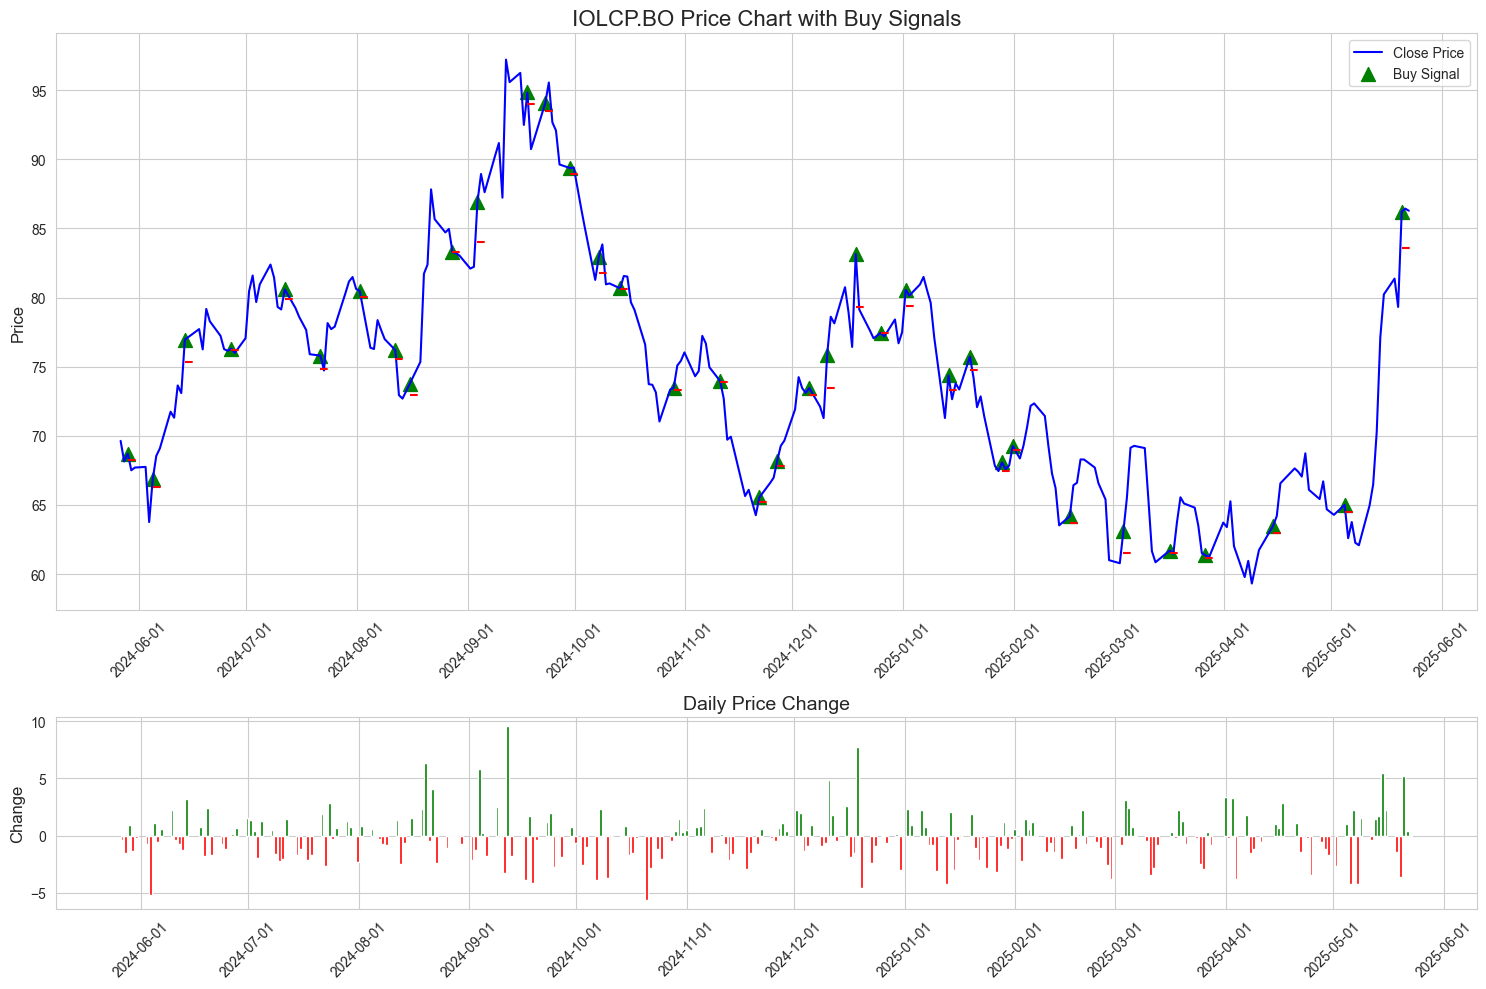

In [ ]:
signals_pd = signals.to_pandas()
signals_pd['Date'] = pd.to_datetime(signals_pd['Date'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(signals_pd['Date'], signals_pd['Price'], label='Close Price', color='blue')

buy_signals_pd = signals_pd[signals_pd['Signal'] == 'Buy']
ax1.scatter(buy_signals_pd['Date'], buy_signals_pd['Price'], 
           color='green', marker='^', s=100, label='Buy Signal')

for _, row in buy_signals_pd.iterrows():
    if row['Stoploss'] is not None:
        ax1.hlines(row['Stoploss'], row['Date'], 
                 row['Date'] + pd.Timedelta(days=3), 
                 colors='red', linestyles='dashed')

ax1.set_title(f'{stock} Price Chart with Buy Signals', fontsize=16)
ax1.set_ylabel('Price', fontsize=12)
ax1.legend()
ax1.grid(True)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax2.bar(signals_pd['Date'], signals_pd['Price'] - signals_pd['Open'], 
       color=signals_pd.apply(lambda x: 'green' if x['Price'] > x['Open'] else 'red', axis=1))
ax2.set_title('Daily Price Change', fontsize=14)
ax2.set_ylabel('Change', fontsize=12)
ax2.grid(True)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

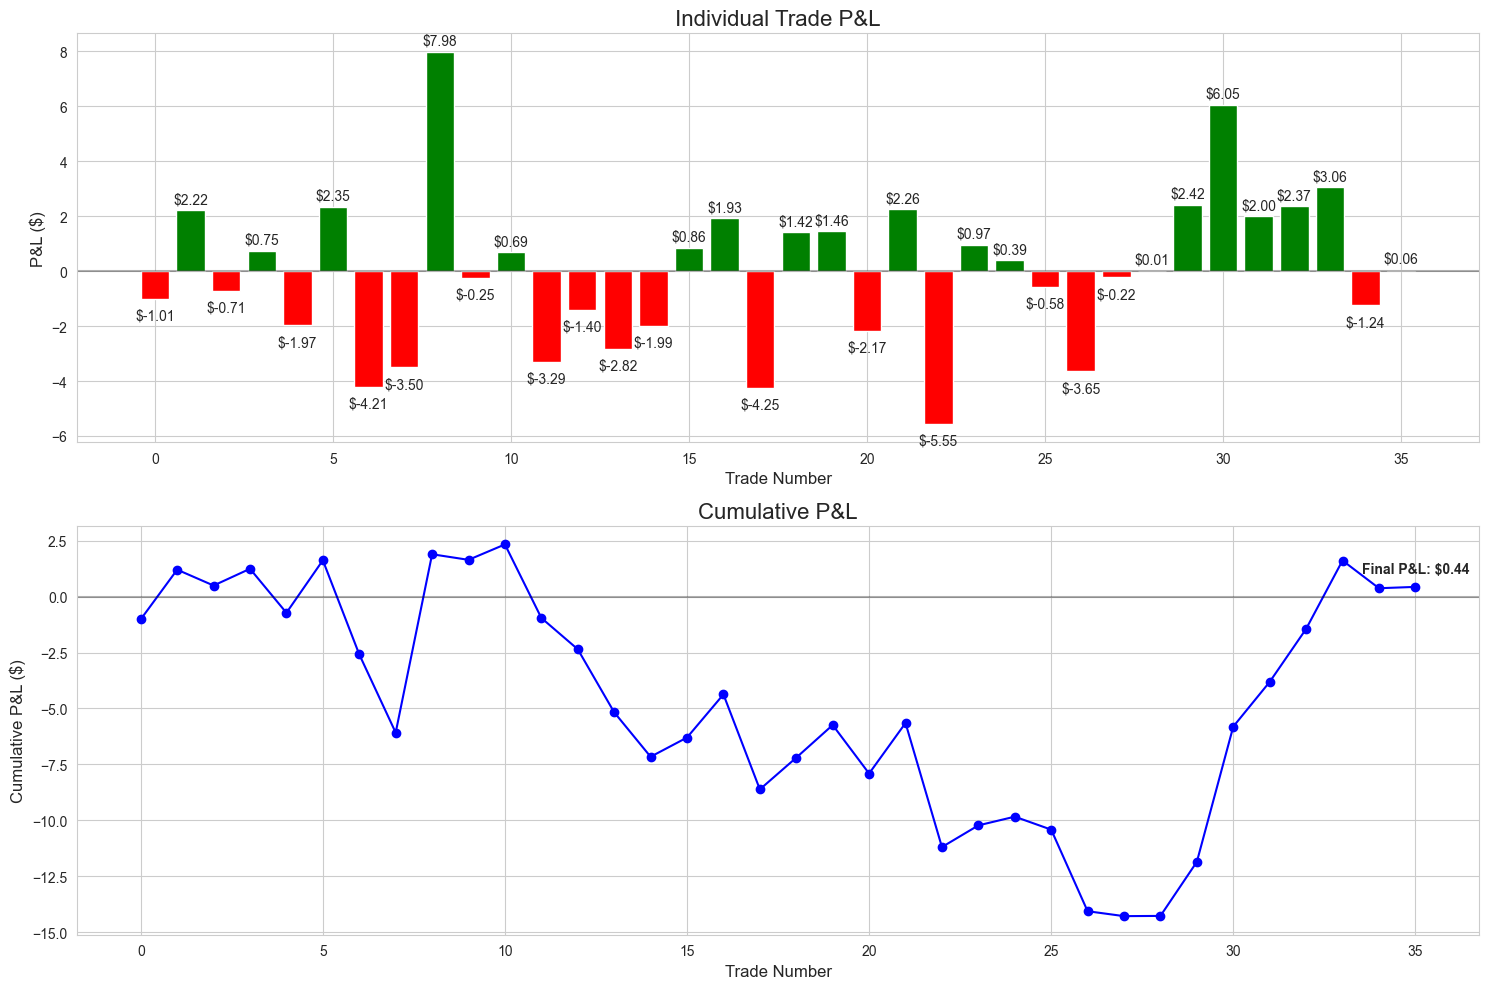

In [ ]:
if len(pnl_report) > 0:
    pnl_pd = pnl_report.to_pandas()
    pnl_pd['Entry_Date'] = pd.to_datetime(pnl_pd['Entry_Date'])
    pnl_pd['Exit_Date'] = pd.to_datetime(pnl_pd['Exit_Date'])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    colors = ['green' if pnl > 0 else 'red' for pnl in pnl_pd['PNL']]
    ax1.bar(range(len(pnl_pd)), pnl_pd['PNL'], color=colors)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_title('Individual Trade P&L', fontsize=16)
    ax1.set_xlabel('Trade Number', fontsize=12)
    ax1.set_ylabel('P&L ($)', fontsize=12)
    
    for i, pnl in enumerate(pnl_pd['PNL']):
        ax1.annotate(f'${pnl:.2f}', 
                   (i, pnl), 
                   textcoords="offset points", 
                   xytext=(0, 5 if pnl >= 0 else -15),
                   ha='center')
    
    cumulative_pnl = pnl_pd['PNL'].cumsum()
    ax2.plot(range(len(cumulative_pnl)), cumulative_pnl, marker='o', color='blue')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title('Cumulative P&L', fontsize=16)
    ax2.set_xlabel('Trade Number', fontsize=12)
    ax2.set_ylabel('Cumulative P&L ($)', fontsize=12)
    ax2.grid(True)
    
    if len(cumulative_pnl) > 0:
        ax2.annotate(f'Final P&L: ${cumulative_pnl.iloc[-1]:.2f}', 
                   xy=(len(cumulative_pnl)-1, cumulative_pnl.iloc[-1]),
                   textcoords="offset points", 
                   xytext=(0, 10),
                   ha='center',
                   fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize")